In [1]:
# imports
import pandas as pd

import sqlalchemy
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

## PART 1: EXTRACT

source: https://docs.google.com/spreadsheets/d/1CxrgdT4Xd8J0N3CuVmkVRryMeIdm93H8rzv8-YlP0kw/

FURTHER WORK:
Web scraping info - 17S turnovers? Votes? GM sheets? Player post counts?

Add Sheets API pull to automate

*Player data ('Data Test' tab)*

In [2]:
player_path = "../datacsvs/DataTest.csv"
playerdata = pd.read_csv(player_path)
playerdata.head()

,ID,Player,Alignment,Faction Outcome,First Hit,Last Hit,# of Hits,Death/\n Survival,Inactive,GM,...,Broken,Role,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,1,Meta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,...,NaN,GM,Roles that are unique and don't fit,NaN,Unfinished,Alignment,Victory,Hits,Survival,NaN
1,2,Cracknut,G,L,1.0,1.0,1.0,E,NaN,NaN,...,NaN,Tineye,MR1/LG8/MR7 need work,NaN,QF7,0,0,13,0,NaN
2,3,Edgedancer,G,L,2.0,2.0,1.0,L,NaN,NaN,...,NaN,Cop,NaN,NaN,MR6,0,0,25,0,NaN
3,4,Mailliw73,G,L,4.0,4.0,1.0,L,NaN,NaN,...,NaN,Regular,NaN,NaN,LG12,0,0,2,0,NaN
4,5,Aether,E,W,4.0,4.0,1.0,V,NaN,NaN,...,NaN,Smoker,NaN,NaN,QF8,0,0,22,0,NaN


*Game data ('Game Stats' tab)*

In [3]:
game_path = "../datacsvs/GameStats.csv"
gamedata = pd.read_csv(game_path)
gamedata.head()

,Game Stats,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176,Unnamed: 177,Unnamed: 178
0,NaN,LG1,LG2,LG3,LG4,QF1,LG5,MR1,LG6,QF2,...,LG69,QF47,LG70,MR45,LG71,QF48,MR46,LG72,QF49,MR47
1,# of Players,16,29,22,30,12,20,27,25,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Total Rank,132,16,59,13,166,84,29,43,140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,# of Spectators,3,2,5,1,11,2,4,5,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Rank,85,97,65,118,37,97,73,65,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## PART 2: TRANSFORM

*FURTHER WORK:*

1) Reduce/flatten non-player data into mod/spec/GM tables

2) Remove game data that can be produced by aggregating player data

3) Game data - split 'LG1' etc into two separate columns

4) Deal with blanks in Hit columns and convert to numerical types

5) Flatten further by giving players an ID and putting them somewhere else; provide tables that are basically keys for alignment, outcome, etc to clarify what they mean (?)

### 2A: Player data
*Initial cleaning*

In [4]:
playerdata.columns

Index(['ID', 'Player', 'Alignment', 'Faction Outcome', 'First Hit', 'Last Hit',
       '# of Hits', 'Death/\n Survival', 'Inactive', 'GM', 'Mod', 'Spec',
       'Game Type', 'Game #', 'Unnamed: 14', 'Broken', 'Role', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24'],
      dtype='object')

In [5]:
# Select useful columns (last few are irrelevant)
pdata = playerdata[["Player", "Alignment", "Faction Outcome", "First Hit", "Last Hit", "# of Hits", 
             "Death/\n Survival", "Inactive", 'GM', 'Mod', 'Spec', 'Game Type', 'Game #', 
             'Unnamed: 14', 'Broken', 'Role']]

# Rename columns for accuracy or simplicity
pdata = pdata.rename(columns = {"Player": "person",
                                "Faction Outcome": "fOutcome", 
                                "First Hit": "Hit1", 
                                "Last Hit": "HitL",
                                "# of Hits": "HitNum", 
                                "Death/\n Survival": "Death", 
                                "Game Type": "gtype",
                                "Game #": "GameNum", 
                                "Unnamed: 14": "Game"})

In [6]:
# Fill in NaN values
pdata = pdata.fillna({"Alignment": 0, 
                       "fOutcome": 0, 
                      "Hit1": "-", 
                      "HitL": "-", 
                      "HitNum": "-", 
                      "Inactive":"N", 
                      "GM":"N", 
                      "Mod": "N", 
                      "Spec": "N", 
                      "Broken": "N", 
                      "Role": "-"})
print(len(pdata))
pdata.head()


5763


,person,Alignment,fOutcome,Hit1,HitL,HitNum,Death,Inactive,GM,Mod,Spec,gtype,GameNum,Game,Broken,Role
0,Meta,0,0,-,-,-,NaN,N,Y,N,N,LG,1.0,LG1,N,GM
1,Cracknut,G,L,1,1,1,E,N,N,N,N,LG,1.0,LG1,N,Tineye
2,Edgedancer,G,L,2,2,1,L,N,N,N,N,LG,1.0,LG1,N,Cop
3,Mailliw73,G,L,4,4,1,L,N,N,N,N,LG,1.0,LG1,N,Regular
4,Aether,E,W,4,4,1,V,N,N,N,N,LG,1.0,LG1,N,Smoker


In [7]:
# separate out mod/spec/GM into separate table

# get indices of all non-players
nonplayers_list = []
it = pdata.iterrows()
i = 0
while i != 5672:
    curr = next(it)
    
    ifmod = curr[1]["Mod"]
    ifGM = curr[1]["GM"]
    ifspec = curr[1]["Spec"]
    
    if (ifmod == "Y") or (ifGM == "Y") or (ifspec == "Y"):
        nonplayers_list.append(curr[0])
    
    i += 1

print(len(nonplayers_list))

# @TODO: SIMPLIFY etc

1461


In [8]:
# pull relevant columns and filter by index list above
nonplayers = pdata.filter(["person", "GM", "Mod", "Spec", "gtype", "GameNum", "Game", "Broken"], axis = 1)
nonplayers = nonplayers.filter(nonplayers_list, axis = 0)

nonplayers.head()
nonplayers.to_csv("../datacsvs/NonPlayerData.csv", index = False)

# to clean further: combine GM/mod/spec into one column, don't need 'Game' probably
# Maybe separate into separate GM/Mod/Spec tables?

In [9]:
# take out nonplayers to create players dataframe
playerlist = [j for j in range(5763) if j not in nonplayers_list]

players = pdata.filter(playerlist, axis = 0)
players = players.drop(['GM', 'Mod', 'Spec'], axis = 1)

players.head()
players.to_csv("../datacsvs/CleanPlayerData.csv", index = False)

### 2B: Game data

In [10]:
gamedata.head()

,Game Stats,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176,Unnamed: 177,Unnamed: 178
0,NaN,LG1,LG2,LG3,LG4,QF1,LG5,MR1,LG6,QF2,...,LG69,QF47,LG70,MR45,LG71,QF48,MR46,LG72,QF49,MR47
1,# of Players,16,29,22,30,12,20,27,25,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Total Rank,132,16,59,13,166,84,29,43,140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,# of Spectators,3,2,5,1,11,2,4,5,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Rank,85,97,65,118,37,97,73,65,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
gdata0 = gamedata.fillna('NA')

# need to transpose entire thing and set first column to be the column headers
# this is a MESS
# maybe when getting data initially, read 1 row first and then feed to pandas? solves header problem partly

cols = gdata0["Game Stats"]

cols

0                  NA
1        # of Players
2          Total Rank
3     # of Spectators
4                Rank
           ...       
73            Faction
74               Draw
75       Free For All
76             No One
77               Misc
Name: Game Stats, Length: 78, dtype: object

In [12]:
cols[0] = "Game"
cols[2] = 'PlayerNumRank'
cols[4] = 'SpecNumRank'
cols

0                Game
1        # of Players
2       PlayerNumRank
3     # of Spectators
4         SpecNumRank
           ...       
73            Faction
74               Draw
75       Free For All
76             No One
77               Misc
Name: Game Stats, Length: 78, dtype: object

In [13]:
gdata1 = gdata0.transpose()

gdata2 = gdata1.rename(columns = cols)

gdata2.head()

,Game,# of Players,PlayerNumRank,# of Spectators,SpecNumRank,# of E. Kills,# of Neutral Evil Kils,# of V. Kills,# of Lynches,# of FF Deaths,...,Faction/Free For All,NA,NA,Eliminator,Village,Faction,Draw,Free For All,No One,Misc
Game Stats,Game,# of Players,PlayerNumRank,# of Spectators,SpecNumRank,# of E. Kills,# of Neutral Evil Kils,# of V. Kills,# of Lynches,# of FF Deaths,...,Faction/Free For All,NA,NA,Eliminator,Village,Faction,Draw,Free For All,No One,Misc
Unnamed: 1,LG1,16,132,3,85,5,0,1,4,0,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Unnamed: 2,LG2,29,16,2,97,14,0,2,7,2,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Unnamed: 3,LG3,22,59,5,65,3,0,1,7,3,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Unnamed: 4,LG4,30,13,1,118,4,0,4,8,4,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [14]:
gdata2 = gdata2.reset_index(drop = True)

In [15]:
gdata2.columns

gdata3 = gdata2[['Game', '# of Players', 'Total Rank', '# of Spectators', 'Rank',
       '# of E. Kills', '# of Neutral Evil Kils', '# of V. Kills',
       '# of Lynches', '# of FF Deaths', '# of Neutral Deaths',
       '# of Inactive Deaths', '# of Deaths', 'Rank', '# of Eliminators',
       'Eliminator Percentage', 'Eliminators Lynched', "Eliminators Vig'd",
       'Thread Reply Count', 'Thread Reply Rank', 'Setting', 'Game Complexity',
       '# of Cycles', 'Winning Team', '# of Survivors', 'Total Rank',
       'Survivors']]

gdata3.head()

,Game,# of Players,Total Rank,# of Spectators,Rank,# of E. Kills,# of Neutral Evil Kils,# of V. Kills,# of Lynches,# of FF Deaths,...,Eliminators Vig'd,Thread Reply Count,Thread Reply Rank,Setting,Game Complexity,# of Cycles,Winning Team,# of Survivors,Total Rank,Survivors
0,Game,# of Players,Total Rank,# of Spectators,Rank,# of E. Kills,# of Neutral Evil Kils,# of V. Kills,# of Lynches,# of FF Deaths,...,Eliminators Vig'd,Thread Reply Count,Thread Reply Rank,Setting,Game Complexity,# of Cycles,Winning Team,# of Survivors,Total Rank,Survivors
1,LG1,16,86,3,121,5,0,1,4,0,...,1,462,79,Cosmere,Basic,4,Eliminator,6,86,Claincy
2,LG2,29,49,2,5,14,0,2,7,2,...,2,"1,232",11,Cosmere,Standard,11,Eliminator,4,49,Aether
3,LG3,22,112,5,67,3,0,1,7,3,...,1,739,41,Cosmere,Basic,7,Village,8,112,Meta
4,LG4,30,123,1,23,4,0,4,8,4,...,4,"1,029",22,Cosmere,Standard,9,Village,9,123,Mailliw73


In [16]:
gdata3 = gdata3.drop(0, axis = 0)
gdata3.head()

# TODO: split 'Game' into # and format
gdata3.to_csv('../datacsvs/CleanGameData.csv')

In [17]:
gdata3.tail()

,Game,# of Players,Total Rank,# of Spectators,Rank,# of E. Kills,# of Neutral Evil Kils,# of V. Kills,# of Lynches,# of FF Deaths,...,Eliminators Vig'd,Thread Reply Count,Thread Reply Rank,Setting,Game Complexity,# of Cycles,Winning Team,# of Survivors,Total Rank,Survivors
174,QF48,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
175,MR46,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
176,LG72,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
177,QF49,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
178,MR47,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### 2C: Analysis & Graphs
TODO: pull data from SQL pls

In [18]:
pnums = gdata3['# of Players'].replace(to_replace = 'NA', value = '0').astype(int)

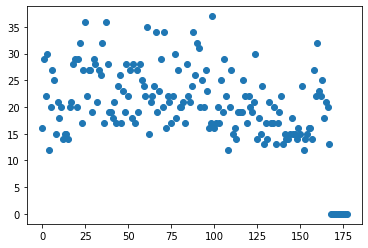

In [19]:
import matplotlib.pyplot as plt

# NUMBER OF PLAYERS PER GAME OVER TIME
fig, ax = plt.subplots()
ax.scatter(range(len(pnums)), pnums)

In [20]:
# NUMBER OF PLAYERS OVER TIME, SEPARATED BY FORMAT

players.head()

formats = players.groupby('gtype')

formats.count()



,person,Alignment,fOutcome,Hit1,HitL,HitNum,Death,Inactive,GameNum,Game,Broken,Role
gtype,,,,,,,,,,,,
AG,210,210,210,210,210,210,187,210,210,210,210,210
LG,1690,1690,1690,1690,1690,1690,1555,1690,1690,1690,1690,1690
MR,964,964,964,964,964,964,917,964,964,964,964,964
QF,944,944,944,944,944,944,896,944,944,944,944,944


In [21]:
formatnums = formats['GameNum'].value_counts(sort = False)

formatnums

fn1 = pd.DataFrame(formatnums)
fn1 = fn1.rename(columns = {'GameNum': 'Game #'})
fn2 = fn1.reset_index()

In [22]:
lgnums = players[players['gtype'] == "LG"]['GameNum'].value_counts(sort = False)
mrnums = players[players['gtype'] == "MR"]['GameNum'].value_counts(sort = False)
qfnums = players[players['gtype'] == "QF"]['GameNum'].value_counts(sort = False)

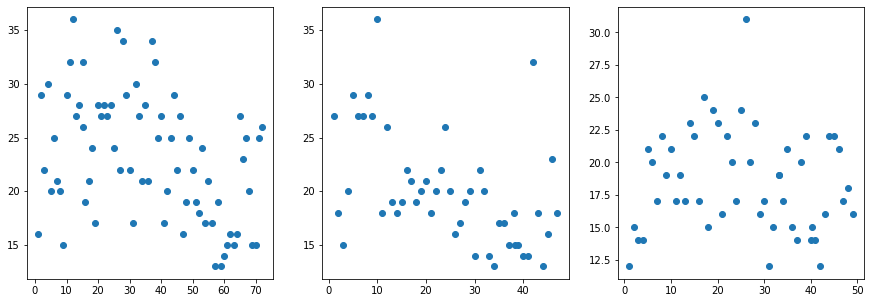

In [23]:

fig1, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15, 5))
ax1.scatter(lgnums.index, lgnums)
ax2.scatter(mrnums.index, mrnums)
ax3.scatter(qfnums.index, qfnums);

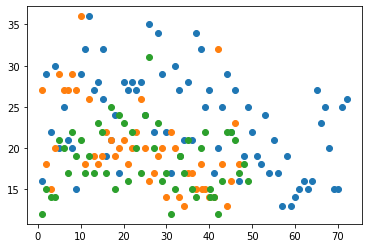

In [24]:

fig1, ax1 = plt.subplots()
ax1.scatter(lgnums.index, lgnums)
ax1.scatter(mrnums.index, mrnums)
ax1.scatter(qfnums.index, qfnums);

## PART 3: LOAD
See `ToMongo.ipynb`. This held code putting the data into a SQL database before I decided to use Mongo instead. 


FURTHER WORK:

1) Get SQLAlchemy classes working to play with data

2) Analyze from SQL data; create aggregations that mimic Main/GameStats/etc

3) Create a Flask app or site to display visualizations. Interactive? 

THE END

.

.

.

.

.

.


for now